In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import casadi
import os

## 1 - Manufacturer data

In [2]:
B0_Q, B1_Q = -68851.589, 313.3151
B0_C, B1_C = 2.695868, -0.008533

def Q_HP_max(T_OA):
    T_OA += 273
    return round((B0_Q + B1_Q*T_OA)/1000,2) if T_OA<273-7 else 14
    
def COP1(T_OA):
    T_OA += 273
    return round(B0_C + B1_C*T_OA,2)

## 2 - Estimating maximum storage capacity

In [3]:
# The maximum storage capacity (kWh)
mass_of_water = 450*4 # 450kg water per tank
max_temp, min_temp = 65, 30 #°C
max_storage = mass_of_water * 4187 * (max_temp - min_temp) # in Joules
max_storage = round(max_storage * 2.77778e-7,1) # in kWh

print(f"The storage capacity is {max_storage} kWh.")

The storage capacity is 73.3 kWh.


## 3 - Forecasts

In [4]:
# Outside air temperature [°C]
T_OA = [-12.52, -12.28, -12.55, -14.18, -13.76, -13.96, -14.26, -14.13, 
        -13.99, -9.65, -6.86, -5.21, -3.69, -2.88, -2.36, -2.29, -3.91, 
        -5.52, -6.13, -6.58, -7.09, -7.43, -7.99, -8.68] 

# Load [kWh]
load = [8.12, 8.07, 8.13, 8.57, 8.46, 8.51, 8.59, 8.55, 8.52, 7.4, 
        6.69, 6.26, 5.87, 5.68, 5.52, 5.5, 5.92, 6.34, 6.49, 6.61, 6.74, 6.81, 6.94, 7.15] 

In [5]:
# Electricity prices [cts/kWh]
price_type = "progressive"

if price_type == "gridworks":
    c_el = [6.36, 6.34, 6.34, 6.37, 6.41, 6.46, 6.95, 41.51,
            41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64,
            41.43, 41.51, 6.84, 6.65, 6.46, 6.4]

elif price_type == "progressive":
    c_el = [18.97, 18.92, 18.21, 16.58, 16.27, 15.49, 14.64,
            18.93, 45.56, 26.42, 18.0, 17.17, 16.19, 30.74, 31.17, 16.18,
            17.11, 20.24, 24.94, 24.69, 26.48, 30.15, 23.14, 24.11]

elif price_type == "peter":
    c_el = [0.07919, 0.066283, 0.063061, 0.067943, 0.080084, 0.115845, 
                0.193755, 0.215921, 0.110822, 0.044927, 0.01521, 0.00742, 
                0.004151, 0.007117, 0.009745, 0.02452, 0.037877, 0.09556, 
                0.205067, 0.282588, 0.234866, 0.184225, 0.132268, 0.101679]
    c_el = [x*100 for x in c_el]

In [6]:
# Q_HP_max forecast from T_OA [kWh_th]
Q_HP_max_list = [Q_HP_max(temp) for temp in T_OA]
Q_HP_min_list = [8 for x in Q_HP_max_list]

# 1/COP forecast from T_OA
COP1_list = [COP1(temp) for temp in T_OA]

### Overview

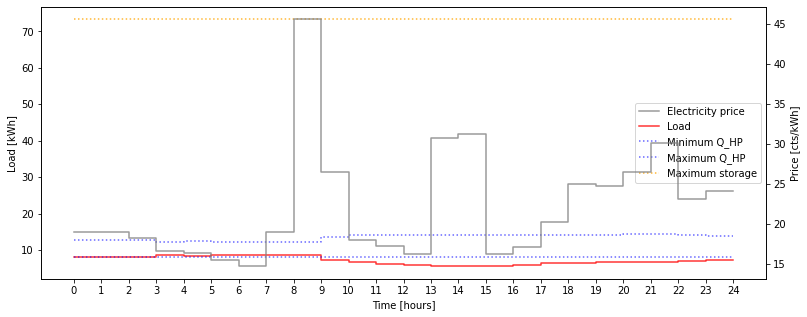

In [7]:
# Duplicate the last element of the hourly data for the plot
c_el2 = c_el + [c_el[-1]]
load2 = load + [load[-1]]
Q_min2 = Q_HP_min_list + [Q_HP_min_list[-1]]
Q_max2 = Q_HP_max_list + [Q_HP_max_list[-1]]

N = len(c_el)
fig, ax = plt.subplots(1,1, figsize=(13,5))
ax2 = ax.twinx()
ax2.step(range(N+1), c_el2, where='post', color='gray', alpha=0.8, label='Electricity price')
ax.step(range(N+1), load2, where='post', color='red', alpha=0.8, label='Load')
ax.step(range(N+1), Q_min2, where='post', color='blue', alpha=0.6, label='Minimum Q_HP', linestyle='dotted')
ax.step(range(N+1), Q_max2, where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
ax.step(range(N+1), [max_storage]*(N+1), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
ax.set_xticks(range(N+1))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Load [kWh]")
ax2.set_ylabel("Price [cts/kWh]")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines2 + lines1, labels2 + labels1)
plt.show()

## 4 - Optimization

In [8]:
def get_opti(c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list):

    # Initialize    
    opti = casadi.Opti('conic')

    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    storage = opti.variable(1,N+1)  # state
    Q_HP = opti.variable(1,N)       # input
    HP_on_off = opti.variable(1,N)  # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # HP_on_off is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete':discrete_var, 'gurobi.OutputFlag':0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(storage[0] == storage_initial)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(storage[t] >= 0)
        opti.subject_to(storage[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(storage[t+1] == storage[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(HP_on_off[t] >= 0)
            opti.subject_to(HP_on_off[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= Q_HP_max_list[t])    
            opti.subject_to(Q_HP[t] >= Q_HP_min_list[t]*HP_on_off[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= Q_HP_max_list[t]*HP_on_off[t])
            opti.subject_to(Q_HP_onoff[t] >= Q_HP_min_list[t]*HP_on_off[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + Q_HP_min_list[t]*(HP_on_off[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + Q_HP_max_list[t]*(HP_on_off[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*c_el[t]*COP1_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------
    
    sol = opti.solve()
    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(storage)
    HP_on_off_opt = sol.value(HP_on_off)
    obj_opt = round(sol.value(obj)/100,2)

    return Q_opt, stor_opt, HP_on_off_opt, obj_opt

## 5 - Open loop MPC, horizon 24 hours

Academic license - for non-commercial use only
Academic license - for non-commercial use only


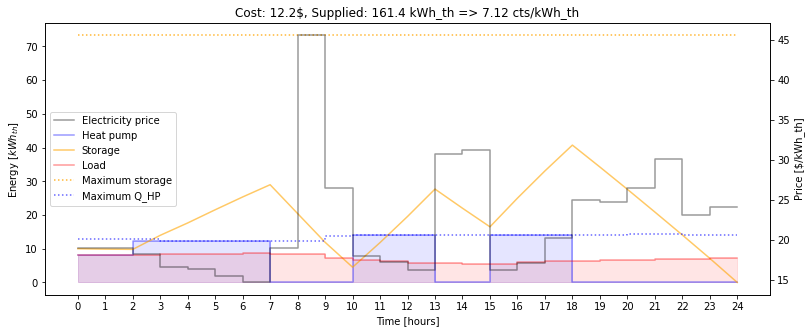

In [9]:
# Get the solution from the optimization problem
storage_initial = 10
Q_opt, stor_opt, HP_on_off_opt, obj_opt \
= get_opti(c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list)

# Horizon
N = 24

# Duplicate the last element of the hourly data for the plot
c_el2 = c_el + [c_el[-1]]
Q_opt2 = [round(x,3) for x in Q_opt] + [Q_opt[-1]]
load2 = load + [load[-1]]

# Plot
fig, ax = plt.subplots(1,1, figsize=(13,5))
ax.step(range(N+1), Q_opt2, where='post', label='Heat pump', alpha=0.4, color='blue')
ax.plot(range(N+1), stor_opt, label='Storage', alpha=0.6, color='orange')
ax.step(range(N+1), load2, where='post', label='Load', alpha=0.4, color='red')
ax.step(range(N+1), [max_storage]*(N+1), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
ax.step(range(N+1), Q_max2, where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
ax.fill_between(range(N+1), load2, step="post", color='red', alpha=0.1)
ax.fill_between(range(N+1), Q_opt2, step="post", color='blue', alpha=0.1)
ax.set_xticks(range(N+1))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Energy [$kWh_{th}$]")
plt.title(f"Cost: {obj_opt}$, Supplied: {round(sum(Q_opt2),1)} kWh_th => {round(100*obj_opt/sum(load),2)} cts/kWh_th")
ax2 = ax.twinx()
ax2.set_ylabel("Price [$/kWh_th]")
ax2.step(range(N+1), c_el2, where='post', label='Electricity price', color='black', alpha = 0.4)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines2 + lines1, labels2 + labels1)
plt.show()

## 5 - Closed-loop MPC, horizon 24 hours

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

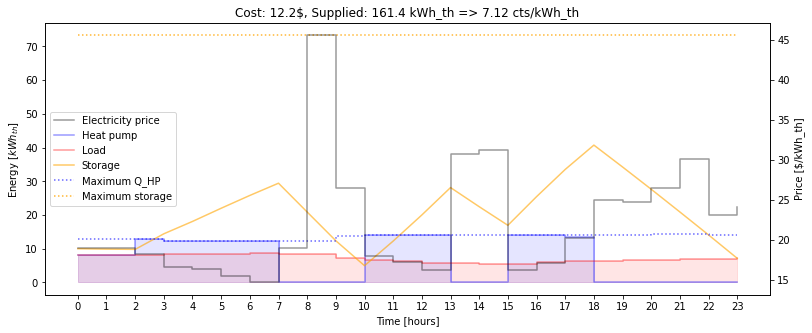

In [10]:
# Horizon (hours)
N = 24

# 24 hour simulation
num_iterations = 24

# Duplicate forecasts to allow for longer simulations
c_el = c_el*20
load = load*20
Q_HP_max_list = Q_HP_max_list*20
Q_HP_min_list = Q_HP_min_list*20
COP1_list = COP1_list*20

initial_storage = 10
Q_opt_overall, stor_opt_overall = [], []
cost_total = 0

# Add the receiding horizon, 8 hour horizon
for iter in range(num_iterations):

    # Update forecasts for new interation
    c_el_current = c_el[iter:iter+N]
    load_current = load[iter:iter+N]
    Q_HP_min_list_current = Q_HP_min_list[iter:iter+N]
    Q_HP_max_list_current = Q_HP_max_list[iter:iter+N]

    # Get optimal solution for next N steps
    Q_opt, stor_opt, HP_on_off_opt, obj_opt = \
    get_opti(c_el_current, load_current, max_storage, initial_storage, Q_HP_min_list_current, Q_HP_max_list_current)

    # Next state of the system
    initial_storage = stor_opt[1]

    # Apprend what you did in this hour
    Q_opt_overall.append(Q_opt[0])
    stor_opt_overall.append(stor_opt[0])
    cost_total += (Q_opt[0] * c_el_current[0])*COP1(T_OA[iter])/100
    #print(HP_on_off_opt)
    
    # Duplicate the last element of the hourly data for the plot
    c_el2 = c_el_current + [c_el_current[-1]]
    Q_opt2 = [round(x,3) for x in Q_opt] + [Q_opt[-1]]
    load2 = load_current + [load_current[-1]]
    
    # To plot each iteration (open loop results)
    plot_each_iteration = False
    if plot_each_iteration:
        fig, ax = plt.subplots(1,1, figsize=(13,5))
        ax.step(range(N+1), Q_opt2, where='post', label='Heat pump', alpha=0.4, color='blue')
        ax.plot(range(N+1), stor_opt, label='Storage', alpha=0.6, color='orange')
        ax.step(range(N+1), load2, where='post', label='Load', alpha=0.4, color='red')
        ax.set_xticks(range(N+1))
        ax.set_xlabel("Time [hours]")
        ax.set_ylabel("Energy [$kWh_{th}$]")
        plt.title(f"Cost: {obj_opt}$, Supplied: {round(sum(load),1)} kWh_th \n=> {round(100*obj_opt/sum(load),2)} cts/kWh_th")
        ax2 = ax.twinx()
        ax2.set_ylabel("Price [$/kWh_th]")
        ax2.step(range(N+1), c_el2, where='post', label='Electricity price', color='black', alpha = 0.4)
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines2 + lines1, labels2 + labels1)
        plt.show()

# Plot closed-loop result
fig, ax = plt.subplots(1,1, figsize=(13,5))
ax.step(range(num_iterations), Q_opt_overall, where='post', label='Heat pump', alpha=0.4, color='blue')
ax.step(range(num_iterations), load[:num_iterations], where='post', label='Load', alpha=0.4, color='red')
ax.plot(range(num_iterations), stor_opt_overall, label='Storage', alpha=0.6, color='orange')
ax.step(range(num_iterations), Q_max2[:num_iterations], where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
ax.step(range(num_iterations), [max_storage]*(num_iterations), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
ax.fill_between(range(num_iterations), load[:num_iterations], step="post", color='red', alpha=0.1)
ax.fill_between(range(num_iterations), Q_opt_overall, step="post", color='blue', alpha=0.1)
ax.set_xticks(range(num_iterations))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Energy [$kWh_{th}$]")
ax2 = ax.twinx()
ax2.set_ylabel("Price [$/kWh_th]")
ax2.step(range(num_iterations), c_el[:num_iterations], where='post', label='Electricity price', color='black', alpha = 0.4)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines2 + lines1, labels2 + labels1)
plt.title(f"Cost: {round(cost_total,1)}$, Supplied: {round(sum(Q_opt_overall),1)} kWh_th => {round(100*cost_total/sum(load[:num_iterations]),2)} cts/kWh_th")
plt.show()

In [11]:
# Give these as a suggestion, and if not feasible, turn on HP cheapest first !